In [1]:
# ✅ Cell 1: Essential Imports and Device Setup

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ✅ Configure GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")



✅ Using device: cuda


In [2]:
# ⚙️ Data augmentation and normalization
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 📁 Load datasets from folder structure
train_data = datasets.ImageFolder("split_dataset/train", transform=image_transforms)
val_data   = datasets.ImageFolder("split_dataset/val", transform=image_transforms)
test_data  = datasets.ImageFolder("split_dataset/test", transform=image_transforms)

# 📦 Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# 🏷️ Get class names
class_names = train_data.classes
print(f"✅ Classes detected: {class_names}")

✅ Classes detected: ['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']


In [3]:
# ✅ Cell 3: Model Setup + Training with Early Stopping

# 🔍 Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# 🎯 Fine-tune last two layers + FC
for name, param in model.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# 🔁 Replace final layer with output for 6 classes
num_classes = len(class_names)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# ⚙️ Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 🛑 Early Stopping
best_val_loss = float('inf')
patience = 4
counter = 0

# 📊 Training loop
epochs = 15
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # 📉 Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    val_acc = 100 * correct / total

    # ✅ Early Stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), "best_car_damage_model.pth")
        print("✅ Model improved — saved!")
    else:
        counter += 1
        print(f"⚠️ No improvement. EarlyStop patience: {counter}/{patience}")
        if counter >= patience:
            print("🛑 Early stopping triggered.")
            break

    print(f"📘 Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")


C:\Users\gokul\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\gokul\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Model improved — saved!
📘 Epoch 1/15 | Train Loss: 1.0919 | Val Loss: 0.7792 | Val Acc: 67.42%
✅ Model improved — saved!
📘 Epoch 2/15 | Train Loss: 0.6253 | Val Loss: 0.6693 | Val Acc: 73.23%
⚠️ No improvement. EarlyStop patience: 1/4
📘 Epoch 3/15 | Train Loss: 0.4261 | Val Loss: 0.6846 | Val Acc: 72.47%
✅ Model improved — saved!
📘 Epoch 4/15 | Train Loss: 0.2961 | Val Loss: 0.6487 | Val Acc: 75.00%
⚠️ No improvement. EarlyStop patience: 1/4
📘 Epoch 5/15 | Train Loss: 0.2162 | Val Loss: 0.7089 | Val Acc: 75.00%
⚠️ No improvement. EarlyStop patience: 2/4
📘 Epoch 6/15 | Train Loss: 0.1438 | Val Loss: 0.7491 | Val Acc: 72.22%
⚠️ No improvement. EarlyStop patience: 3/4
📘 Epoch 7/15 | Train Loss: 0.1193 | Val Loss: 0.7658 | Val Acc: 74.49%
⚠️ No improvement. EarlyStop patience: 4/4
🛑 Early stopping triggered.


✅ Classification Report:
              precision    recall  f1-score   support

  F_Breakage       0.80      0.76      0.78        51
   F_Crushed       0.67      0.73      0.70        41
    F_Normal       0.65      0.55      0.59        20
  R_Breakage       0.72      0.77      0.74        30
   R_Crushed       0.63      0.80      0.71        30
    R_Normal       0.95      0.67      0.78        30

    accuracy                           0.73       202
   macro avg       0.74      0.71      0.72       202
weighted avg       0.74      0.73      0.73       202

✅ Confusion Matrix:
[[39  9  2  1  0  0]
 [ 7 30  4  0  0  0]
 [ 3  6 11  0  0  0]
 [ 0  0  0 23  7  0]
 [ 0  0  0  5 24  1]
 [ 0  0  0  3  7 20]]


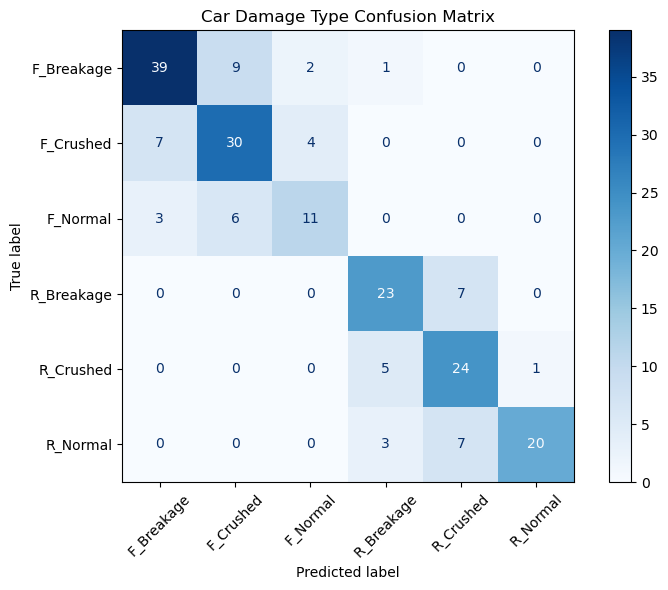

In [4]:
# 🧠 Load the best model weights before evaluation
model.load_state_dict(torch.load("best_car_damage_model.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 📋 Classification Report
print("✅ Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# 📊 Confusion Matrix
print("✅ Confusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
print(cm)

# 🖼️ Visualize the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", xticks_rotation=45, ax=ax)
plt.title("Car Damage Type Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()


In [6]:
torch.save(model.state_dict(), "car_damage_model.pth")
print("✅ Model saved as car_damage_model.pth")


✅ Model saved as car_damage_model.pth
